#### About

resnet50 with fixed size of 224x224

#### Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import fastai
from fastai.vision import *

In [2]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.43.post1
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset

In [3]:
# download the dataset
URL = 'https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip'
file = download_data(URL); file

# uncompress the data
# TODO: remove hard-coding
! cd /home/ubuntu/.fastai/data; mv ChestXRay2017.zip.tgz ChestXRay2017.zip; unzip ChestXRay2017.zip

PosixPath('/home/ubuntu/.fastai/data/ChestXRay2017.zip.tgz')

In [20]:
# see what files we've got
path = file.parent/'chest_xray'
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/.DS_Store'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/test'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train')]

In [24]:
Path(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/PNEUMONIA'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/.DS_Store')]

In [21]:
# show some sample paths to the images
get_image_files(path/'train/NORMAL')[:5]

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0545-0001-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0427-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0648-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0660-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0637-0001.jpeg')]

torch.Size([3, 1580, 1924])


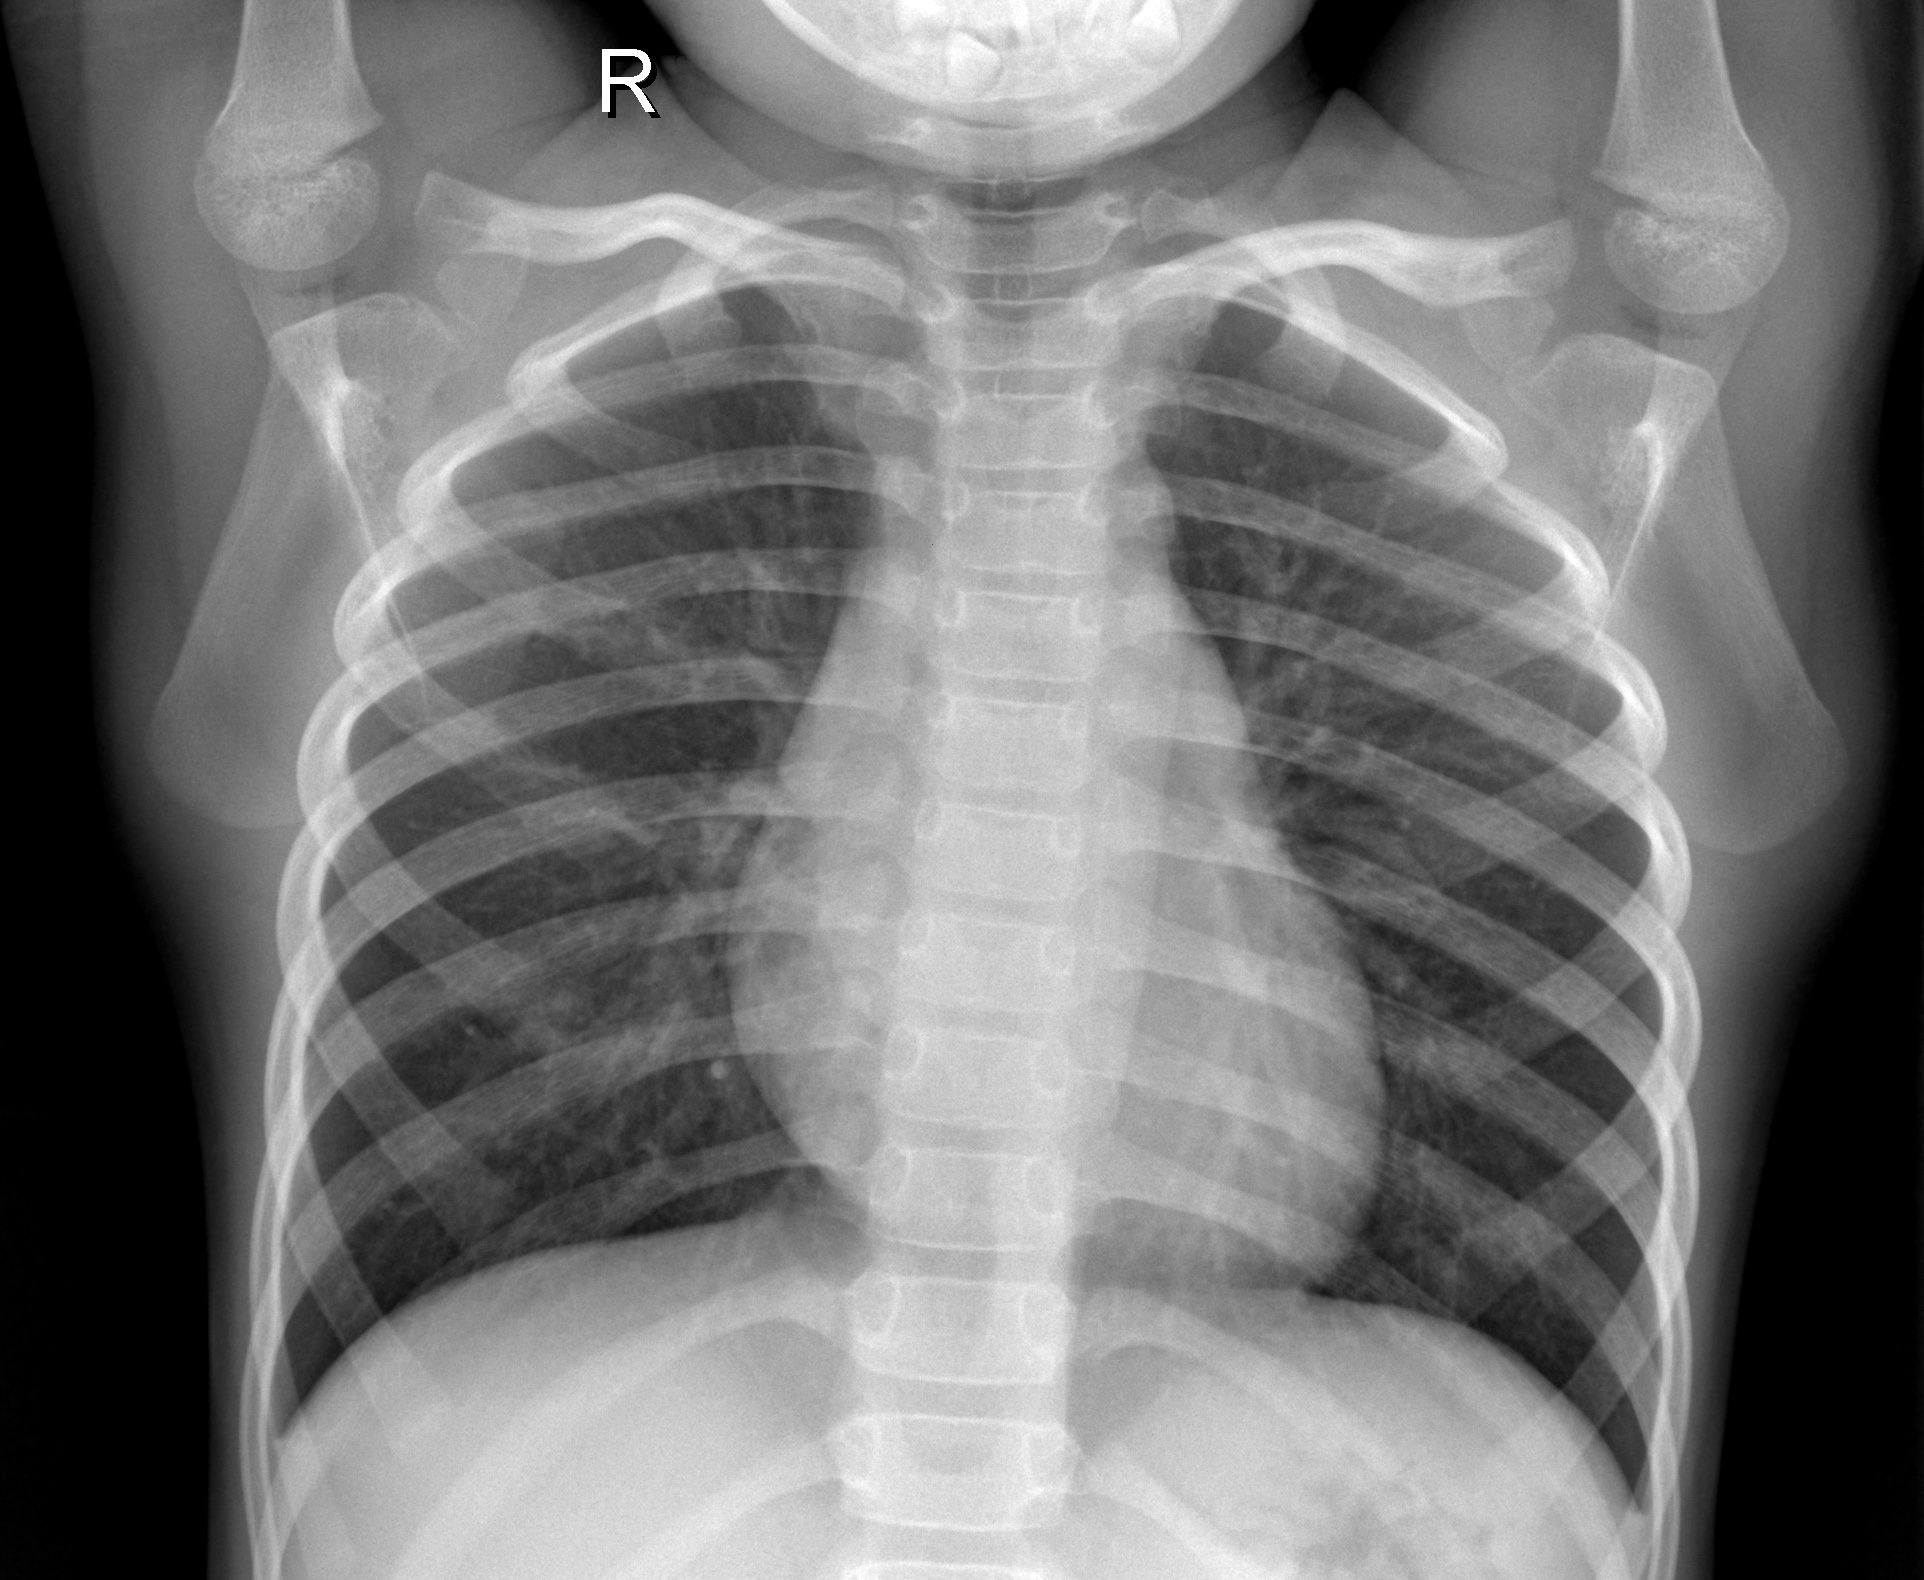

In [25]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'train/NORMAL')[0])
print(img.shape)
img

In [31]:
# see how much data there is
print('train/NORMAL:   ', len(os.listdir(path/'train/NORMAL')))
print('train/PNEUMONIA:', len(os.listdir(path/'train/PNEUMONIA')))
print('test/NORMAL:    ', len(os.listdir(path/'test/NORMAL')))
print('test/PNEUMONIA: ', len(os.listdir(path/'test/PNEUMONIA')))

train/NORMAL:    1349
train/PNEUMONIA: 3884
test/NORMAL:     234
test/PNEUMONIA:  390


#### Create datablock

In [32]:
# set hyperparamters
np.random.seed(42)
size = 224
bs = 64
num_workers = 4

In [33]:
# define data augmentation transformations
tfms = get_transforms()

Because we have a labeled test set, we'll be using the `test` directory as the valdation set.

In [35]:
src = (ImageItemList.from_folder(path)
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

In [36]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [37]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

5232
624


In [38]:
data.classes

['NORMAL', 'PNEUMONIA']

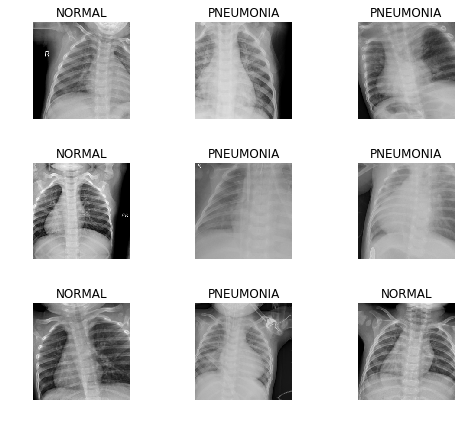

In [39]:
data.show_batch(rows=3, figsize=(7,6))

#### Create model

In [40]:
# define architecture
arch = models.resnet50

In [41]:
# create learner
learn = create_cnn(data, arch, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


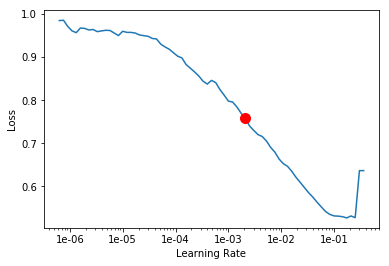

In [42]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [43]:
lr = 2.1e-3

#### Train on frozen model

In [44]:
# first fit the head of the model
learn.fit_one_cycle(4, slice(lr))

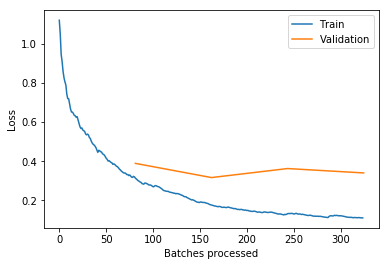

In [45]:
learn.recorder.plot_losses()

In [46]:
learn.save('stage-1-size224')

#### Train on unfrozen model

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06


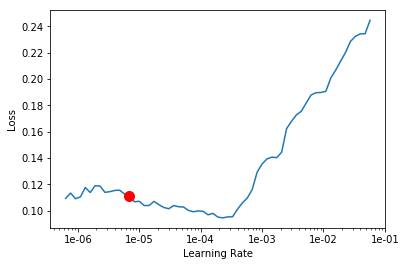

In [48]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [49]:
# now fit across the entire model
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

In [50]:
learn.save('stage-2-size224')

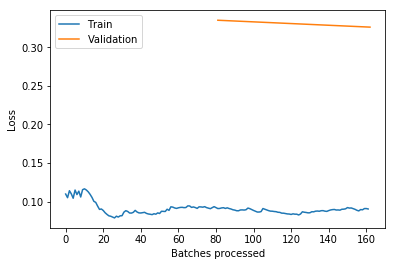

In [51]:
learn.recorder.plot_losses()

#### Look at results

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

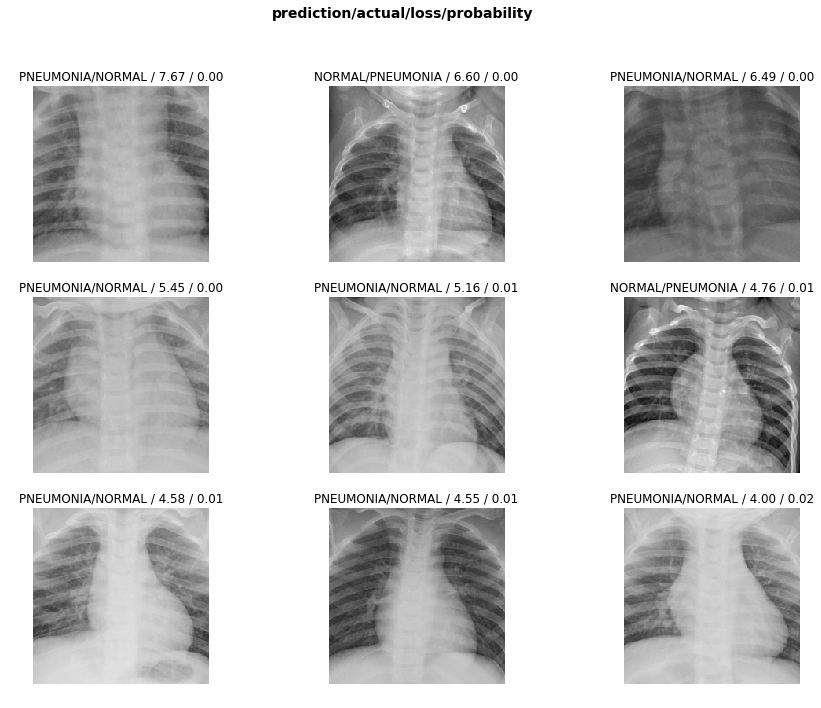

In [53]:
interp.plot_top_losses(9, figsize=(15,11))

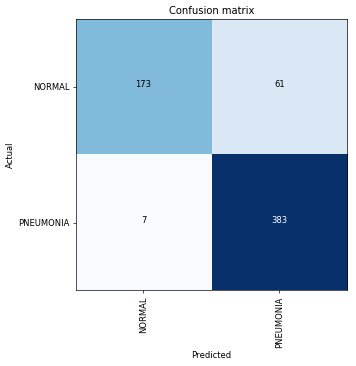

In [54]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [55]:
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 61), ('PNEUMONIA', 'NORMAL', 7)]

Calculate precision and recall.
* Precision is a measure of how often we were correct out of all the times we predicted pneumonia.  The error here is cases that were fine that we thought were pneumonia.
* Recall is a measure of how often we correctly predicted pneumonia out of all the actual pneumonia cases.  The error here is actual pneumonia cases that we failed to detect.  For these types of medical applications its probably better to optimize for this number.

In [56]:
(tn, fp), (fn, tp) = interp.confusion_matrix()

In [57]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [58]:
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.86
Recall: 0.98
